# Fractal drum

Nori Parelius

This project was a part of an exam in Computational Physics that I took in May 2015. At the time I used Fortran to solve it, but I have since rewritten it in Matlab and now Python. 

The project is about finding the eigenvalues and eigenvectors of a "fractal drum" - a thin membrane stretched on a frame with a fractal shaped border. The fractal is a square Koch fractal.

Oscillations of this drum's membrane follow the wave equation
\begin{equation}
\nabla^2 u=\frac{1}{v^2}\frac{\partial^2 u}{\partial t^2},
\end{equation}
with $u$ being the displacement, $v$ velocity and $t$ time. The value of $u$ at the boundary (where the membrane is attached to the frame) is always 0. Fourier transforming the wave equation over time gives the Helmholtz equation:
\begin{equation}
-\nabla^2U(\vec{x},\omega)=\frac{\omega^2}{v^2}U(\vec{x},\omega), \quad \rm{in}\ \Omega,
\end{equation}
where $U$ is the Fourier transform of $u$ and $\omega$ is angular frequency. And for the Dirichlet boundary condition $u=0$
\begin{equation}
U(\vec{x},\omega)=0, \quad \rm{on}\ \partial \Omega
\end{equation}

Using a finite difference approximation for the Laplacian operator, the Helmholtz equation is transformed into a form
\begin{equation}
LU=\frac{\omega^2}{v^2}U
\end{equation}
where $L$ is a matrix generated from the Laplacian operator and taking into account the boundary conditions and $U$ is a vector containing the displacements for each point within the boundary.
This equation is an eigenvalue problem which means that matrix $L$ can be used to find eigenvalues $\omega^2/v^2$ and corresponding eigenvectors $U$ for which the equation is true.  

To find the eigenvalues, several steps have to be taken. First the shape of the fractal boundary has to be generated and positioned onto a spatial grid so that all the corners in the boundary fall onto grid points. Then it is necessary to find out which grid points are within the boundary and which are outside, as only the points inside will be a part of the vector $U$ from the eigenvalue problem. The matrix $L$ is then generated from the finite difference scheme for the Laplace operator and using the boundary conditions. The last step is to solve the eigenvalue problem. 

## 1. Creating the fractal border on a grid

### Importing libraries

In [4]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline

### Making the fractal shape
The fractal border is created by first defining a square, given by the coordinates of its corners. Function FRACTAL takes the coordinates of two points and creates a Koch square fractal from the line. It returnes the coordinates of the corners of this fractal. Function FRACTALIZE then uses function FRACTAL to do this for several connected lines, such as the starting square. The function FRACTALIZE applies the "fractalization" f_level times.

In [32]:
# length of the side
L_side=4.0 

# position of top left corner
LT=[5.0,9.0] 

# number of times the initial square will be "fractalized"
f_level=2



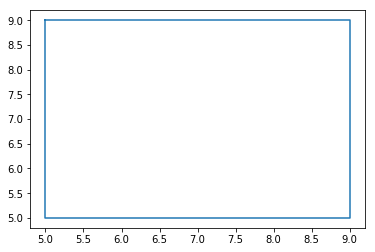

In [33]:
# Initializing the square
corners=np.zeros((5,2))
corners[0,:]=LT
corners[1,:]=[corners[0,0]+L_side,corners[0,1]]
corners[2,:]=[corners[0,0]+L_side,corners[0,1]-L_side]
corners[3,:]=[corners[0,0],corners[0,1]-L_side]
corners[4,:]=corners[0,:]
plt.plot(corners[:,0],corners[:,1])

In [34]:
def fractal(A,B):
    '''
    FUNCTION FRACTAL takes as input the coordinates of two points A and B, 2D
    only, and they should either have the same x or y coordinate. And returns
    an array of points that give the Koch fractal shape
    '''

    f=np.zeros((9,2));
    f[0,:]=A
    f[8,:]=B

    if abs(A[0]-B[0]) > abs(A[1]-B[1]): # horizontal
        c=1.0
    else: # vertical
        c=-1.0


    # Points on the line connecting A and B
    step=1; # how far from A we are stepping, for first point 1 step, then 2
    for i in [1,4,7]: # which point in f it is
        for coor in range(2): # which coordinate, x or y
            f[i,coor]=A[coor]+step*(B[coor]-A[coor])/4.0
        step=step+1

    # Points on the line to one direction
    step=1;
    for i in range(2,4,1):
        f[i,0]=A[0]+step*(B[0]-A[0])/4.0+c*(B[1]-A[1])/4.0
        f[i,1]=A[1]+step*(B[1]-A[1])/4.0+c*(B[0]-A[0])/4.0
        step=step+1

    # Points on the line to the other direction
    step=2;
    for i in range(5,7,1):
        f[i,0]=A[0]+step*(B[0]-A[0])/4.0-c*(B[1]-A[1])/4.0
        f[i,1]=A[1]+step*(B[1]-A[1])/4.0-c*(B[0]-A[0])/4.0
        step=step+1
    return f

#### Example of a Koch fractal

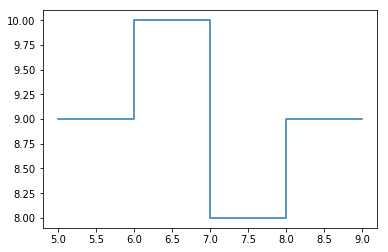

In [35]:
new_fractal=fractal(corners[0,:],corners[1,:])
plt.plot(new_fractal[:,0],new_fractal[:,1])

In [36]:
def fractalize(corners,f_level):
    '''
    Function that takes an array containing coordinates of corners 
    of a closed shape (first and last corner the same) and fractalizes each
    segment f_level number of times
    '''
    for k in range(f_level):
        n_sides=corners.shape[0]-1;
        corn=np.zeros((8*(n_sides-1)+9,2))
        corn[0,:]=corners[0,:]
        for i in range(1,n_sides+1):
            corn_new=fractal(corners[i-1,:],corners[i,:])
            corn[(8*(i-1)):(8*i+1),:]=corn_new
        corners=corn
    return corners

#### Fractalizing

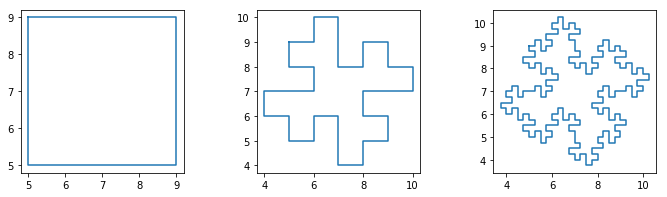

In [37]:
f=fractalize(corners,f_level)
fig, axes=plt.subplots(nrows=1,ncols=3,figsize=(12,3))
axes[0].plot(corners[:,0],corners[:,1])
axes[1].plot(fractalize(corners,1)[:,0],fractalize(corners,1)[:,1])
axes[2].plot(f[:,0],f[:,1])
for ax in axes:
    ax.set_aspect('equal')

### Grid to put the drum on
I created a square lattice that the border will be positioned on. This lattice is the minimum size necessary to cover the whole border structure. This means that the edge of the lattice is further out from the initial square box. This grid offset depends on $l$. For each $l$ the fractal border is moved outside by $L\_side/4$ where length is the length of the side at previous $l$. This adds up to $L\_side/4+L\_side/4^2+L\_side/4^3+...L\_side/4^f\_level$, where $L\_side$ is the length of the side of the initial box. One grid constant $\delta$ was added to the offset. 

Grid constant $\delta$ was chosen depending on the desired $f\_level$. If each corner of the fractal border is supposed to fall onto a grid point for any $f\_level<f\_level_{max}$ then 
\begin{equation}
\delta=\frac{L\_side}{4^{f\_level_{max}}}.
\end{equation}
In addition, for $f\_level=1$ with this grid spacing (meaning corners on the grid but no additional grid points between them), there would be only one point within the boundaries. For $f\_level>1$ this is not the case any more, but I have anyway defined a variable which allows to add grid points so that the grid is more dense than the corners of fractal shape.
\begin{equation}
\delta=\frac{L\_side}{4^{f\_level_{max}}(points\_between+1)},
\end{equation}
where $n_{points\_between}$ is the number of added points between, not including, the corners.
As a result, I had to make a routine that would add these points to my array of corners and create an array containing all the edge points.

In [7]:
# Grid parameters
# number of grid points between corner points
points_between=1

# With each iteration, the border grows by 1/4 of L_side
grid_offset=np.sum(L_side/4**(np.arange(1,f_level+1)))

# Step of the grid, so that points between fall on it too
delta= L_side/(4**f_level)/(points_between+1)

# Origin of the grid, with the offset and with adding one point at the edge
grid_origin=[LT[0]-grid_offset-delta,LT[1]+grid_offset+delta]

# Number of grid points in both directions
n_grid=int((L_side+2*grid_offset+2*delta)/delta+1)

#### Adding more points between the corners, on the grid

In [21]:
def fill_edges(corners,MP):
    '''
    Function that takes the corners and adds a given number (MP) of points
    between them, to fill out all the grid points that have an edge
    '''
    n_points=corners.shape[0]
    n_sides=n_points-1
    edges=np.zeros((n_points+n_sides*MP,2))
    
    for i in range(n_sides):
        for coor in range(2): # x y coordinates
            edges[((MP+1)*i):((MP+1)*(i+1)+1),coor]=corners[i,coor]+(corners[i+1,coor]-corners[i,coor])/(MP+1)*range(MP+2)
    return edges

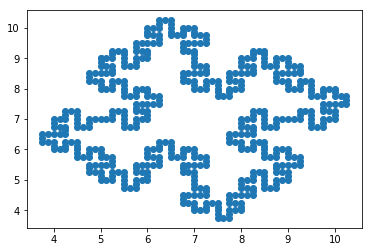

In [23]:
# Filling in the edges
edges=fill_edges(f,points_between)
plt.plot(edges[:,0],edges[:,1],marker='o')

## Identifying border, inside and outside grid points
To know which points are inside and which points are outside, I have created a mask, a two dimensional array of the same size as the grid, that for each point given its position in the array $mask(i,j)$ holds a value defining whether the point is in, out or on the border of the drum. The $mask$ for boundary points is -1, for points outside it is -2 and for points inside it holds the index of the point - from 0 to # points inside -1. 

In [38]:
# Grid
x=grid_origin[0]+delta*np.arange(n_grid)
y=grid_origin[1]-delta*np.arange(n_grid)

First function MASK_EDGES sets in the first step all the mask to -2. Next, using the coordinates(x, y) of the edge points the $mask$ is set to -1 for these edge points. The positions (i, j) of these points in the $mas$k were found by rearranging  the equation that generated the physical coordinates x and y,
\begin{equation}
x=A_x+(i-1)\delta \quad \rm{and}\ y=A_y-(j-1)\delta.
\end{equation}
Where $A_x$ and $A_y$ are the x and y coordinates of the top left corner of the grid.

In [39]:
def mask_edges(n_grid,delta,LeftTop,edges):
    '''
    FUNCTION MASK_EDGES creates an array the size of the grid (n_grid) and
    puts its value to -1 everywhere, except for the points that belong to the
    edges, which are 0, this is calculated by using the (x,y) coordinates of the edges
    give in edges
    x=LTx+(i-1)delta --> i=(x-LTx)/delta +1
    y=LTy-(j-1)delta --> j=-(y-LTy)/delta +1
    '''
    me=-2*np.ones((n_grid,n_grid))
    for point in range(edges.shape[0]-1):
        me[int((edges[point,0]-LeftTop[0])/delta),
           int((LeftTop[1]-edges[point,1])/delta)]=0
    return me

Function INSIDE cycles through each of the points of the grid checking whether the point is inside the polygon.The algorithm consists of deciding how many times a horizontal line passing through the point in question crosses a side of the polygon on the left and on the right of the point. If the number of intersections to the left and to the right is odd, than the point is inside the polygon.

This procedure does not give clear results for the points that are right on the boundary, but these points are already known from the initial mask returned by MASK_EDGES.


In [40]:
def point_in_polygon(e,P):
    '''
    FUNCTION POINT_IN_POLYGON takes as input the coordinates of the edge
    points and the coordinates of the point in question P and returns a
    boolean p depending on whether the point is inside the polygon or not.
    Using the number of times a horizontal line passing through the point
    crosses some segment
    '''
    x=P[0]
    y=P[1]
    
    p=False
    n_corners=e.shape[0]-1
    
    j=n_corners-1
    for i in range(n_corners):
        #it is horizontally between the end points
        if e[i,1]<y and e[j,1] >= y or e[j,1]<y and e[i,1]>=y:
            #whether x is right of the segment
            if e[i,0]+(y-e[i,1])/(e[j,1]-e[i,1])*(e[j,0]-e[i,0])<x:
                p=not p
        j=i
    return p

In [41]:
def inside(edges,x,y,mask):
    '''
    FUNCTION INSIDE takes the edge points, the x and y points of the grid and
    the mask with the edges being 0, rest being -1. It uses point_in_polygon
    to find out if the point is in or out and then sets insides to numbers 1 
    and upwards (counting them), edge to 0 and outside to -1
    '''
    n_grid=x.shape[0]
    me=np.zeros((n_grid,n_grid))
    n_inside=0
    for i in range(n_grid):
        for j in range(n_grid):
            # Find if it's in (1) or out (0)
            me[i,j]=point_in_polygon(edges,[x[i],y[j]])
            # If it's out, set it to -2,
            # if it's in, number it and count it
            if me[i,j]==0: # out
                me[i,j]=-2
                # If it corresponds to an edge point, set it to -1
                if mask[i,j]==-1:
                    me[i,j]=-1
            else: # in
                # If it corresponds to an edge point, set it to -1
                if mask[i,j]==-1:
                    me[i,j]=-1
                else:
                    me[i,j]=n_inside;
                    n_inside=n_inside+1;
    return me,n_inside

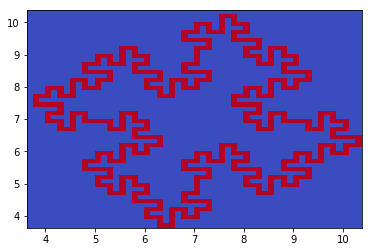

In [42]:
from matplotlib import cm
# First all -1, edges 0
mask1=mask_edges(n_grid,delta,grid_origin,edges) 
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots()
ax.pcolormesh(X,Y,mask1,cmap=cm.coolwarm)


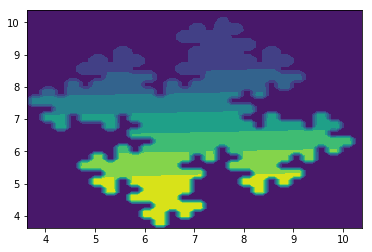

In [51]:
mask,n_in=inside(edges,x,y,mask1)
fig, ax = plt.subplots()
ax.contourf(X,Y,mask)

### The Laplacian matrix
By using a Taylor expansion on the Laplace operator, we get
\begin{equation}
-\nabla^2u(x,y) \approx \frac{1}{\delta^2}(4u(x,y)-u(x-\delta,y)-u(x+\delta,y)-u(x,y-\delta)-u(x,y+\delta)).
\end{equation} 
Applying this to the discretized x and y, with step $\delta$ leads to the 5-point central finite difference approximation of the Laplace, and this gives for our eigenvalue matrix equation ($LU=\frac{\omega^2}{v^2}U$):
\begin{equation}
4u_{i,j}-u_{i-1,j}-u_{i+1,j}-u_{i,j-1}-u_{i,j+1}=\omega^2/v^2\ \delta^2 u_{i,j}.
\end{equation}
This equation can be turned into a matrix equation
\begin{equation}
\frac{1}{\delta^2}L\ V=\frac{\omega^2}{v^2}V,
\end{equation}
where $V=[V_k]$ is a vector that holds values $u_{i,j}$ for i,j such that the corresponding point is within the fractal boundary, and $L$ is a matrix that has the value 4 on its diagonal and up to four times the value -1 in each row i, depending on whether the neigbouring points of $u_{i,i}$ are inside the boundary, or not. 

This means that the matrix $L$ has to be constructed with the shape of the boundary taken into account. 

To construct the matrix, I have created an array $n2grid$ that allows to turn the index of the drum point (the number held by the $mask$) into its position on the grid. 

In [44]:
# Vector containing the grid coordinates of each point on the inside, 
n2grid=np.zeros((n_in,2))
for i in range(n_grid):
    for j in range(n_grid):
        if mask[i,j]>=0:
            n2grid[int(mask[i,j]),:]=[i,j]
               

In [45]:
def matrix_laplace(mask,n2grid,n_in,delta):
    '''
    FUNCTION LAP_MAT returns the Laplacian matrix for the points inside the
    drum
    '''
    mat_lap=np.zeros((n_in,n_in))
    for i in range(n_in): # one row of the laplacian at a time
        mat_lap[i,i]=4.0/delta**2 # the diagonal is 4
        for ii in [-1,1]:
            if mask[int(n2grid[i,0]+ii),int(n2grid[i,1])]>=0: # if the neighbour at x+-1 is inside the drum
                mat_lap[i,int(mask[int(n2grid[i,0]+ii),int(n2grid[i,1])])]=-1.0/delta**2
            if mask[int(n2grid[i,0]),int(n2grid[i,1]+ii)]>=0: # same for y dir
                mat_lap[i,int(mask[int(n2grid[i,0]),int(n2grid[i,1]+ii)])]=-1.0/delta**2 
    return mat_lap

In [52]:
# Creating the Laplacian
laplace=matrix_laplace(mask,n2grid,n_in,delta)

### Solving the eigenvalue problem

In [47]:
# Getting the eigenvalues and eigenvectors
eigenval,evec=np.linalg.eig(laplace)

# Sorting them from lowest to largest
idx = eigenval.argsort()  
eigenval = eigenval[idx]
evec = evec[:,idx]

In [53]:
# First five eigenvalues
print(eigenval[0:4])

[4.27736565 8.42218947 8.42218947 8.74559167]


In [72]:
U=np.zeros((n_grid,n_grid,5))
for n in range(5):
    for i in range(n_in):
        U[int(n2grid[i,0]),int(n2grid[i,1]),n]=evec[i,n]

### The plots of the first 5 vibrational modes
The following plots show the first five eigenvectors plotted onto the grid. These represent the displacement of each drum points, so we are basically looking at how the drum membrane would physically move. The real life vibration would be a combination of these and other modes.

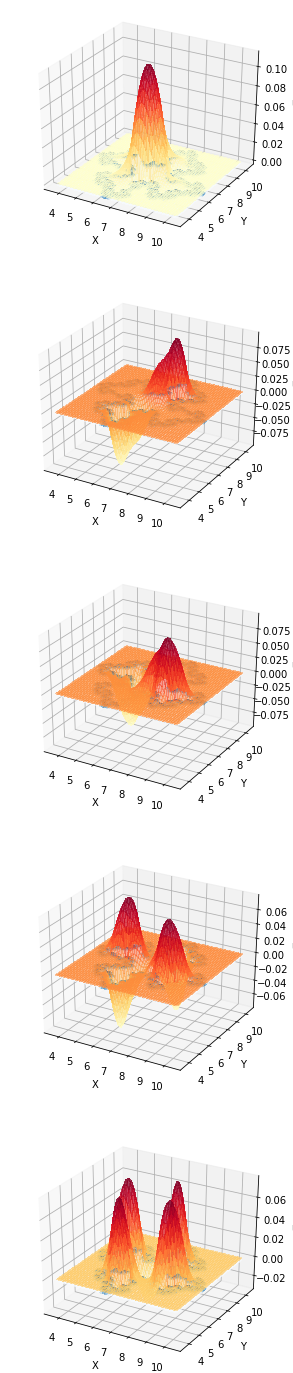

In [73]:
from mpl_toolkits.mplot3d import Axes3D

fig=plt.figure(figsize=(5,25))

X, Y = np.meshgrid(x, y)

# Plot the surface.
for i in range(5):
    ax[i]= fig.add_subplot(5,1,i+1, projection='3d')
    ax[i].plot_surface(X, Y, U[:,:,i],rstride=1,cstride=1, cmap=cm.YlOrRd,
                       linewidth=0, antialiased=False,alpha=0.5) 
    ax[i].plot_surface(X,Y,0.001*mask1,rstride=1,cstride=1,cmap=cm.Blues,linewidth=0,
        antialiased=False,alpha=0.5)   
    ax[i].set_xlabel("X")
    ax[i].set_ylabel("Y")
    ax[i].set_zlabel("U")
